### Build TensorFlow Dataset

In [ ]:
# !pip uninstall tensorflow -y
# !python3 -m venv .venv
# !source .venv/bin/activate
# !pip install tensorflow==2.15.0
# # The cuXXX (CUDA) wheels are Linux-only, NVIDIA GPU-only
# # !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# # Use the official PyPI source, or the command from the PyTorch website for macOS!
# !pip install torch torchvision torchaudio
# !pip install pandas pydicom scikit-learn seaborn

#### Set Parameters

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import torch
import pydicom
import ast
import os
from pathlib import Path

# Set TensorFlow logging level to suppress warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Global configuration
INPUT_SHAPE = (512, 512, 1)
TARGET_SIZE = INPUT_SHAPE[:2]
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
#  Check TensorFlow version and GPU availability
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.0
Num GPUs Available: 1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Check PyTorch version and GPU availability
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
# Never use the cuXXX index for macOS!
# Use the official PyPI source, or the command from the PyTorch website.
# print("Current device:", torch.cuda.current_device())
# print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

PyTorch version: 2.7.0
CUDA available: False
CUDA device count: 0


#### Helper Functions

In [5]:
# DICOM Loader
# Load and normalize a DICOM image from a byte string path
def load_dicom_image(path_tensor):
    path = path_tensor.decode('utf-8')  # Decode byte string to UTF-8
    try:
        ds = pydicom.dcmread(path)
        img = ds.pixel_array.astype(np.float32)
        img -= np.min(img)
        img /= (np.max(img) + 1e-6)  # normalize to [0,1]
    except Exception as e:
        print(f"[DICOM ERROR] {path}: {e}")
        img = np.zeros(TARGET_SIZE, dtype=np.float32)
    return img

# TensorFlow Wrappers
# Load and preprocess a single full mammogram image
def tf_load_dicom(path):
    # img = tf.numpy_function(load_dicom_image, [path], tf.float32)
    img = tf.numpy_function(func=load_dicom_image, inp=[path], Tout=tf.float32)
    img.set_shape([None, None])  # initially 2D
    img = tf.expand_dims(img, axis=-1)  # [H, W, 1]
    img.set_shape([None, None, 1])
    img = tf.image.resize(img, TARGET_SIZE)
    return img

def tf_load_multiple_dicom(paths):
    # paths: tf.Tensor of shape [N] (string paths)
    def load_single(path):
        img = tf.numpy_function(load_dicom_image, [path], tf.float32)
        img.set_shape([None, None])
        img = tf.expand_dims(img, axis=-1)
        img.set_shape([None, None, 1])
        img = tf.image.resize(img, TARGET_SIZE)
        return img

    masks = tf.map_fn(
        load_single,
        paths,
        fn_output_signature=tf.TensorSpec(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 1), dtype=tf.float32)
    )
    return tf.reduce_max(masks, axis=0)  # union of all masks

# Unified MTL Preprocessor
# Load and preprocess multiple ROI masks and combine into a single mask tensor
def load_and_preprocess(image_path, mask_paths, label):
    image = tf_load_dicom(image_path)  # (512, 512, 1)
    mask = tf_load_multiple_dicom(mask_paths)  # (512, 512, 1)
    label = tf.cast(label, tf.float32)
    return image, {"segmentation": mask, "classification": label}

# Parse a dictionary record into image + MTL target dict
def parse_record(record):
    image_path = record['image_path']
    mask_paths = record['mask_paths']
    label = record['label']

    image, target = load_and_preprocess(image_path, mask_paths, label)
    return image, target

# Build tf.data.Dataset from metadata CSV
def build_tf_dataset(
    metadata_csv: str,
    batch_size: int = 8,
    shuffle: bool = True
) -> tf.data.Dataset:

    # Load metadata CSV
    df = pd.read_csv(metadata_csv)

    # Parse stringified list of mask_paths
    df['mask_paths'] = df['mask_paths'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

    # Ensure label column is float32-compatible (e.g., 0.0, 1.0)
    df['label'] = df['label'].astype(np.float32)

    # Convert to list of dicts
    records = df[['image_path', 'mask_paths', 'label']].to_dict(orient='records')

    # Create dataset
    ds = tf.data.Dataset.from_generator(
        lambda: (r for r in records),
        output_signature={
            "image_path": tf.TensorSpec(shape=(), dtype=tf.string),
            "mask_paths": tf.TensorSpec(shape=(None,), dtype=tf.string),
            "label": tf.TensorSpec(shape=(), dtype=tf.float32),
        }
    )

    # Apply MTL-compatible mapping function
    ds = ds.map(lambda r: parse_record(r), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(records))

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


The resulting ds is a complete TensorFlow dataset — (image, {"segmentation": mask, "classification": label}), normalized, resized, shuffled, batched, ready for model training and validation.

### Explore the Resulting Dataset

In [6]:
# Build dataset
ds = build_tf_dataset(
    metadata_csv="../data/processed/cbis_ddsm_metadata_full.csv",
    batch_size=8
)

# Preview one batch
for images, targets in ds.take(1):
    print(f"Images batch shape: {images.shape}")  # (8, 512, 512, 1)
    print(f"Masks batch shape: {targets['segmentation'].shape}")     # (8, 512, 512, 1)
    print(f"Labels batch shape: {targets['classification'].shape}")  # (8,)


Images batch shape: (8, 512, 512, 1)
Masks batch shape: (8, 512, 512, 1)
Labels batch shape: (8,)


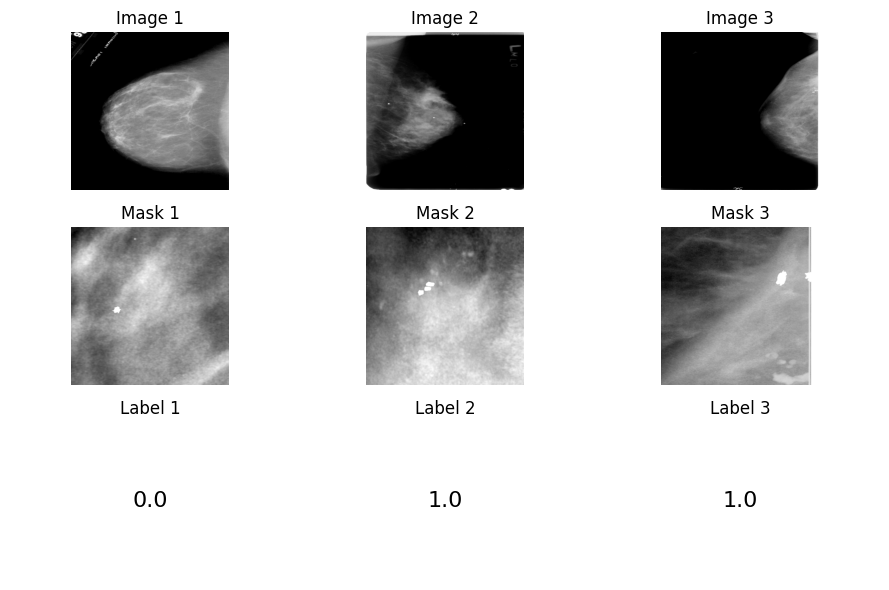

In [ ]:
import matplotlib.pyplot as plt

for images, targets in ds.take(1):
    num_examples = 3  # Number of samples to visualize

    plt.figure(figsize=(num_examples * 3, 6))

    for i in range(num_examples):
        # Plot image
        plt.subplot(3, num_examples, i + 1)
        plt.imshow(images[i, ..., 0], cmap="gray")
        plt.axis("off")
        plt.title(f"Image {i+1}")

        # Plot mask
        plt.subplot(3, num_examples, num_examples + i + 1)
        plt.imshow(targets['segmentation'][i, ..., 0], cmap="gray")
        plt.axis("off")
        plt.title(f"Mask {i+1}")

        # Display the label
        plt.subplot(3, num_examples, 2 * num_examples + i + 1)
        label = targets['classification'][i].numpy()
        plt.text(0.5, 0.5, str(label), fontsize=16, ha='center', va='center')
        plt.axis("off")
        plt.title(f"Label {i+1}")

    plt.tight_layout()
    plt.show()

### Develop a baseline sequential CNN classification model

Develop a baseline convolutional neural network (CNN) model consisting of an encoder and a classification head only. This model will serve as a foundational benchmark, using a series of convolutional and pooling layers followed by fully connected layers for binary (or multiclass) classification, without any segmentation or auxiliary outputs.

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define the baseline sequential CNN classification model
def build_classification_model(input_shape=INPUT_SHAPE):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = GlobalAveragePooling2D()(x)  # Use this instead of Flatten for better generalization
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=output)

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Use new Keras format for saving
checkpoint_cb = ModelCheckpoint("../models/best_model.keras", save_best_only=True, monitor="val_loss")
earlystop_cb = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

metadata = pd.read_csv("../data/processed/cbis_ddsm_metadata_full.csv")
train_meta, val_meta = train_test_split(
    metadata, test_size=0.2, stratify=metadata['label'], random_state=42
)

# Save to new CSV files
train_meta.to_csv("../temporary/train_split.csv", index=False)
val_meta.to_csv("../temporary/val_split.csv", index=False)

# Use your build_tf_dataset as before
train_ds = build_tf_dataset(metadata_csv="../temporary/train_split.csv", batch_size=8)
val_ds = build_tf_dataset(metadata_csv="../temporary/val_split.csv", batch_size=8)

# Keep only the classification label
train_ds = train_ds.map(lambda x, y: (x, y["classification"]))
val_ds = val_ds.map(lambda x, y: (x, y["classification"]))

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

# Build the model
model = build_classification_model(INPUT_SHAPE)

# Train the model
model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4), 
    loss="binary_crossentropy", 
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Proceed with model.fit
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/20
375/375 [==============================] - 81s 89ms/step - loss: 0.6818 - accuracy: 0.5880 - auc: 0.4840 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6779 - val_accuracy: 0.5885 - val_auc: 0.4914 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
375/375 [==============================] - 80s 88ms/step - loss: 0.6762 - accuracy: 0.5877 - auc: 0.5346 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6756 - val_accuracy: 0.5885 - val_auc: 0.5488 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
375/375 [==============================] - 80s 88ms/step - loss: 0.6746 - accuracy: 0.5897 - auc: 0.5484 - precision: 0.5806 - recall: 0.0146 - val_loss: 0.6746 - val_accuracy: 0.5885 - val_auc: 0.5549 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
375/375 [==============================] - 80s 87ms/step - loss: 0.6743 - accuracy: 0.5900 - auc: 0.5536 - precision: 0.5268 - recall: 0.0477 - val_loss: 0.6723 - val_accuracy

### Evaluating and Plotting Metrics

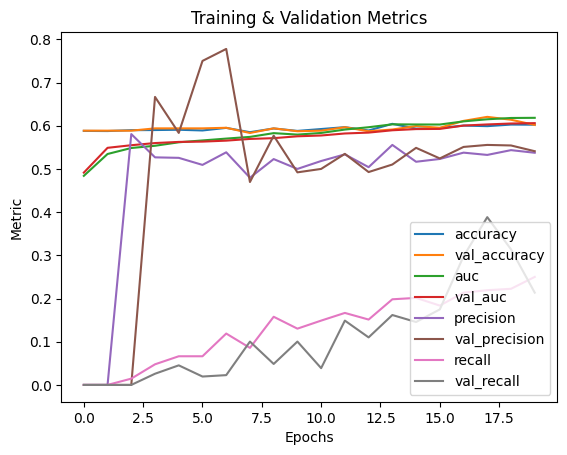

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    metrics = ['accuracy', 'val_accuracy', 'auc', 'val_auc', 'precision', 'val_precision', 'recall', 'val_recall']
    for metric in metrics:
        if metric in history.history:
            plt.plot(history.history[metric], label=metric)
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.title('Training & Validation Metrics')
    plt.show()

plot_training_history(history)

In [15]:
results = model.evaluate(val_ds)
print(dict(zip(model.metrics_names, results)))

94/94 [==============================] - 14s 20ms/step - loss: 0.6631 - accuracy: 0.6019 - auc: 0.6060 - precision: 0.5410 - recall: 0.2136
{'loss': 0.6630808115005493, 'accuracy': 0.6018641591072083, 'auc': 0.6060053706169128, 'precision': 0.5409836173057556, 'recall': 0.21359223127365112}


In [16]:
import numpy as np

# Collect all true labels and predictions
y_true = []
y_pred = []

for x_batch, y_batch in val_ds:
    # Predict probabilities
    probs = model.predict(x_batch)
    # For binary, threshold at 0.5
    preds = (probs.flatten() > 0.5).astype(int)
    y_true.extend(y_batch.numpy().astype(int))
    y_pred.extend(preds)
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 27ms/step


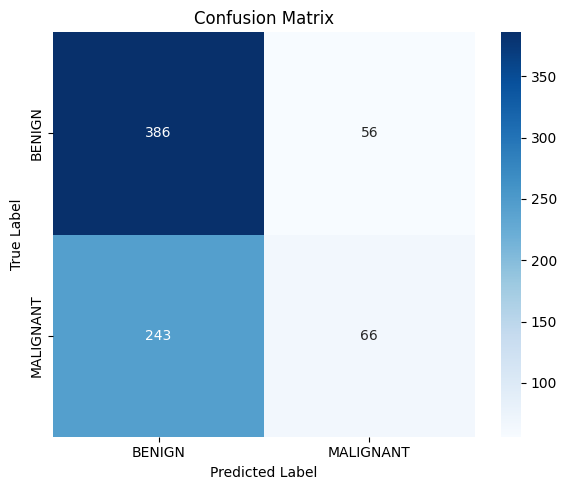

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
labels = ["BENIGN", "MALIGNANT"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


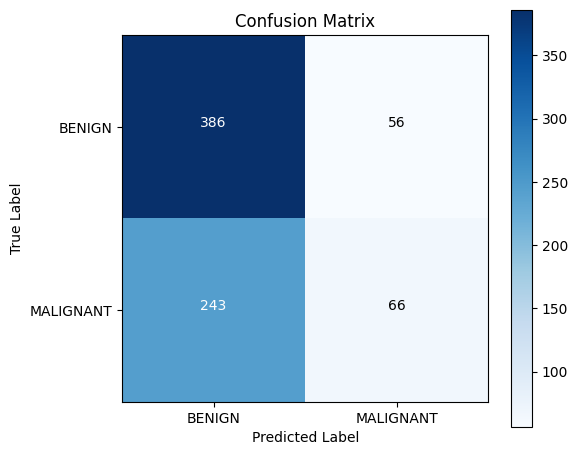

In [20]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
labels = ["BENIGN", "MALIGNANT"]

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Annotate values
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()
